# Multi Layer Perceptron or N-gram Character Level Language Model

This can servce as an introduction to modern day transformer networks like GPT. Here we have a dataset of most common first names of people in USA. We want to build a model that generates new names based on the names in dataset. This based on the paper [Bengio et al 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

# Part 1: Loading and Creating Dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the words dataset file and view first few words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# Total dataset size
len(words)

32033

In [5]:
# Creating a mapping of position to characters present in the dataset
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# Building the dataset with context length
block_size = 3 # character context for next character prediction, so last 3 character is used to predict next character
X, Y = [], []
for w in words:
  context = [0] * block_size # Initially context start with [0,0,0] which is [...]
  for ch in w + '.': # . is the ending character for each word
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # Rolling - the first character of context is removed and the next character is added from word [...]->[..e]
X = torch.tensor(X) # context for train [[...], [..e], [.em]], obviously X contains pos not characters
Y = torch.tensor(Y) # next character pred [e, m, m], obviously Y contains pos not characters
# lets look at first 3 elements of train and pred tensors
print(X[:3])
print(Y[:3])

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13]])
tensor([ 5, 13, 13])


# Part 2: Building and Training the Model

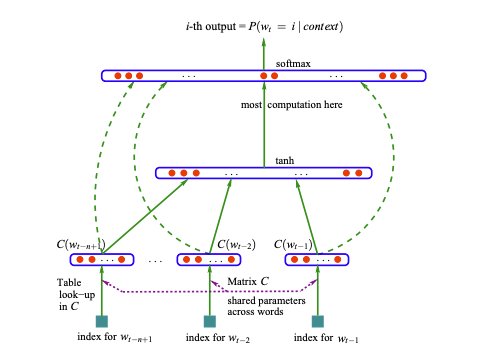

We want to implement a MLP model as per the architecture above, where C is the embedding lookup table, followed by a fully connected layer with tanh as the non linearity, followed by a output connected layer on which we apply softmax to get final probability distribution.

In [45]:
# Lets look at the dimensions of train and pred tensor
X.shape, Y.shape # X - Training example by context length, Y - Training example

(torch.Size([228146, 3]), torch.Size([228146]))

In [46]:
# Lets define the model layers in torch
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g) # Create an embedding lookup initially randomly, embedding space is 2 dim
W1 = torch.randn((6, 100), generator=g) # First FCN weights (context_len*emb_dim, total_neurons), total_neuron in hyperparamter, (context_len*emb_dim) since each train example have those many values
b1 = torch.randn(100, generator=g) # First FCN bias, total_neuron size
W2 = torch.randn((100, 27), generator=g) # Output layer weights (1st FCN total_neuron, total output possible characters)
b2 = torch.randn(27, generator=g) # Output layer bias
parameters = [C, W1, b1, W2, b2]

In [47]:
# Count total number of parameters in our model
sum(p.nelement() for p in parameters)

3481

In [48]:
# Setting all parameters to be trainable by gradient descent
for p in parameters:
  p.requires_grad = True

In [49]:
# Generating exponential learning rate in a range
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [50]:
lri = []
lossi = []
for i in range(50000):
  # Minibatch Construction
  ix = torch.randint(0, X.shape[0], (32,)) # Gets a vector of 32 rows from train X

  # Forward pass and Loss
  emb = C[X[ix]] # (train_size, context_len, emb_dim) get embedding for each train example
  h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (train_size, 100), view is better than cat and unbind since torch stores all tensor values individually in storage and view just manipulates that upper layer and does not create new storage
  # (-1,6) is (train_size, context_len*embed_dim) is moved to this view since next layer can take in this form
  logits = h @ W2 + b2 # (train_size, output chars dim)
  # counts = logits.exp()
  # prob = counts/counts.sum(1, keepdim=True)
  # loss = -prob[torch.arange(X.shape[0]),Y].log().mean()
  loss = F.cross_entropy(logits, Y[ix]) # Cross entropy is same as doing above operations, cross entropy is better since back and for pass is optimised and valeus dont over/under flow

  # Backward pass
  for p in parameters:
    p.grad = None # Set gradients to zero
  loss.backward()

  # lr = lrs[i]
  lr = 0.1
  # Update parameters
  for p in parameters: # Update all parameters of the model
    p.data += -lr*p.grad

  # Tracking progress
  # lri.append(lre[i])
  # lossi.append(loss.item())

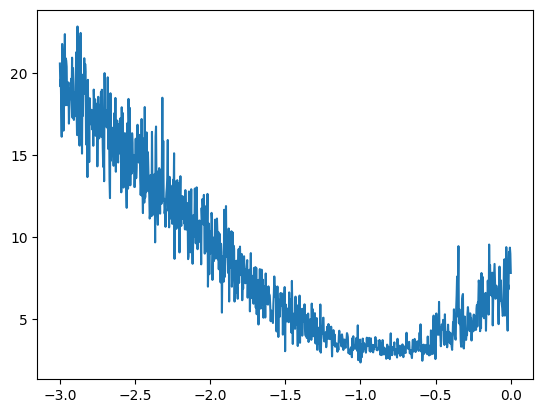

In [36]:
# Plotting for which learning rate gives us the best loss, seems like between 10**(-1.0) to 10**(-0.5) [Do not rerun this]
plt.plot(lri, lossi)

In [51]:
# Get the Loss on entire dataset not on small batch
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3624, grad_fn=<NllLossBackward0>)

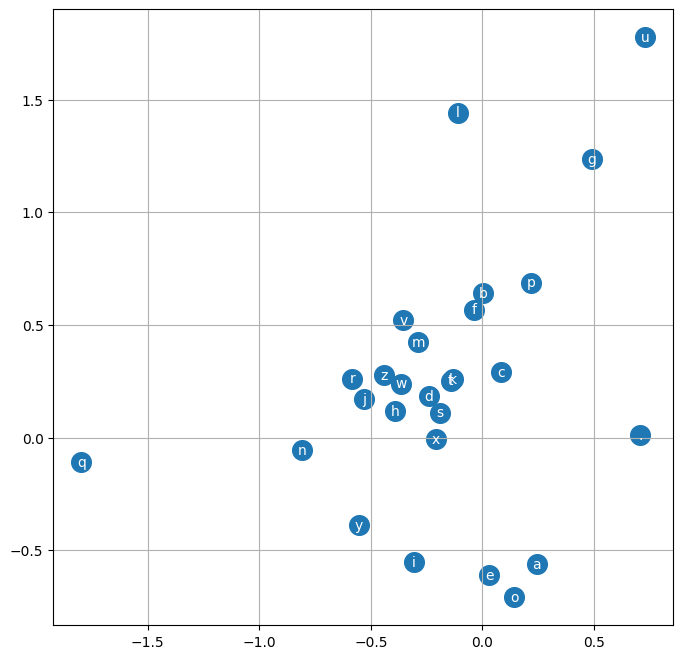

In [52]:
# Lets visualize embedding matrix
# Observation - 1. q,u is very uncommon character 2. vowel aeio are together 3. '.' special character is on its own
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# Part 3: Splitting the dataset and training with optimised hyperparameter

In [53]:
# Now lets divide into train into train (80%), dev/val (10%), test (10%), dev/val is for hyperparameter testing
# We see that our model is getting same loss on train and dev set (no code above take my word for it :) or watch the video) so no overfitting, so we can improve by hperparamter tuning
# Two bottlenecks now -> 1. Increasing the hidden layer size (100->300) 2. Increase the embedding layer dimension (2->10)
# build the dataset

# Creating the dataset again with different splits
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80% of data
Xdev, Ydev = build_dataset(words[n1:n2]) # next 10% of data
Xte, Yte = build_dataset(words[n2:]) # next 10% of data

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [54]:
# Creating the MLP layers
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # Increased Embedding dimension from 3 to 10
W1 = torch.randn((30, 300), generator=g) # Increased hidden layer dimension from 100 to 300
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [55]:
sum(p.nelement() for p in parameters) # number of parameters in total

17697

In [56]:
# Make paramteres trainable
for p in parameters:
  p.requires_grad = True

In [58]:
lossi = []
stepi = []

In [59]:
# Training for 200k iterations over 32 sized mini batch
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 # We take 0.1 lr for first 100k and then 0.01 lr for next 100k
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item()) # We take the log loss

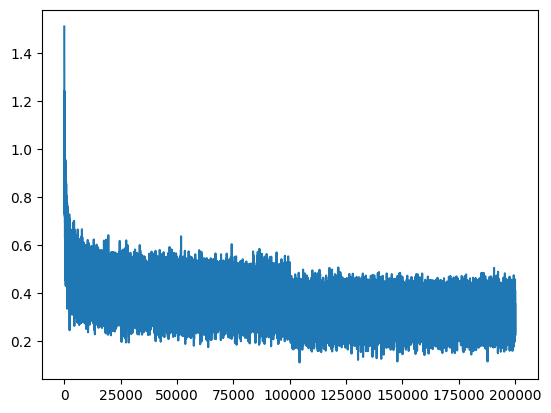

In [60]:
# Plot the loss over time
plt.plot(stepi, lossi)

In [61]:
# Training Loss
emb = C[Xtr] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1296, grad_fn=<NllLossBackward0>)

In [62]:
# Validation loss - Seems like data over fitted a bit
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1973, grad_fn=<NllLossBackward0>)

In [63]:
# Test loss - Seems like data over fitted a bit
emb = C[Xte] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1971, grad_fn=<NllLossBackward0>)

# Part 4: Model Inference

In [64]:
# Make predictions from the model
g = torch.Generator().manual_seed(21474836)
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d) -> (1,3,10)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) # There is only example so 1, and (1,-1) can be writen as (1,30)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

aharyonon.
waynilvia.
eliannedyanis.
azni.
amere.
lynn.
laniel.
azela.
zanvi.
amha.
emmy.
koiettyn.
taadii.
rosa.
jelet.
kadiiamir.
rav.
mais.
finley.
brash.
